In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
import pymc3 as pm


In [4]:
np.random.seed(20090425)
n = 10
X = np.sort(3*np.random.rand(n))[:,None]

# with pm.Model() as model:
# f(x)
l_true = 0.3
s2_f_true = 1.0
cov = s2_f_true * pm.gp.cov.ExpQuad(1, l_true)

# noise, epsilon
s2_n_true = 0.1
K_noise = s2_n_true**2 * tt.eye(n)
K = cov(X) + K_noise

# evaluate the covariance with the given hyperparameters
K = theano.function([], cov(X) + K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
y = np.random.multivariate_normal(np.zeros(n), K)


In [11]:
X.shape, y.shape

((10, 1), (10,))

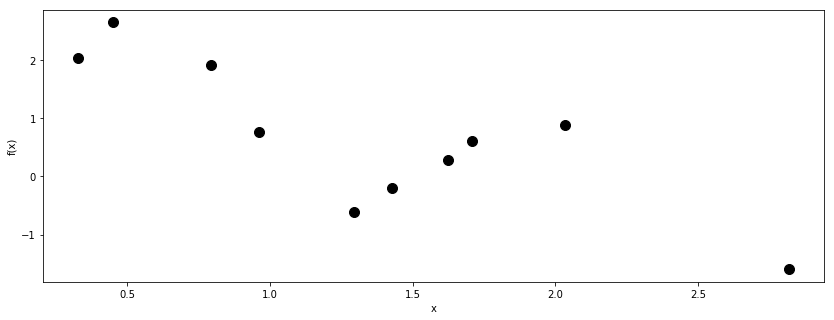

In [5]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");


In [6]:
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.Uniform('l', 0, 10)

    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))

    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':y})


In [7]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -20.781: 100%|██████████| 200000/200000 [01:09<00:00, 2859.51it/s]  
Finished [100%]: Average ELBO = -20.801
100%|██████████| 2000/2000 [00:18<00:00, 105.80it/s]


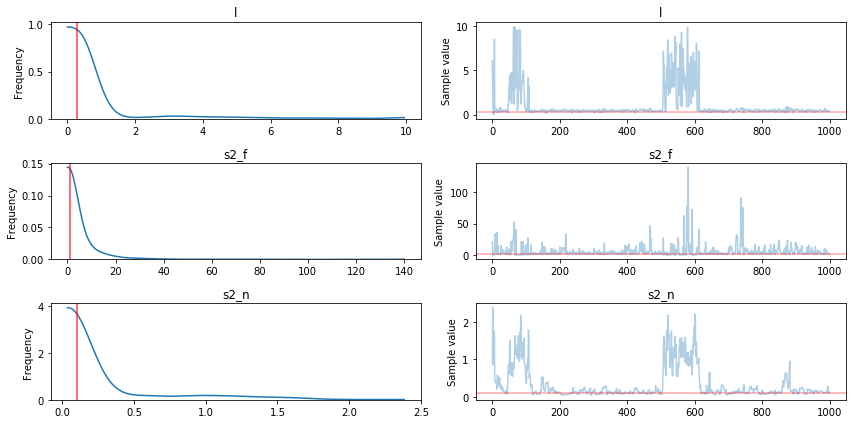

In [8]:
pm.traceplot(trace[1000:], varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

In [9]:
Z = np.linspace(0,3,100)[:,None]
with model:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_obs, Z, samples=50, random_seed=42)

  0%|          | 0/50 [00:00<?, ?it/s]/home/ericmjl/anaconda/lib/python3.6/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 50/50 [00:02<00:00, 21.61it/s]


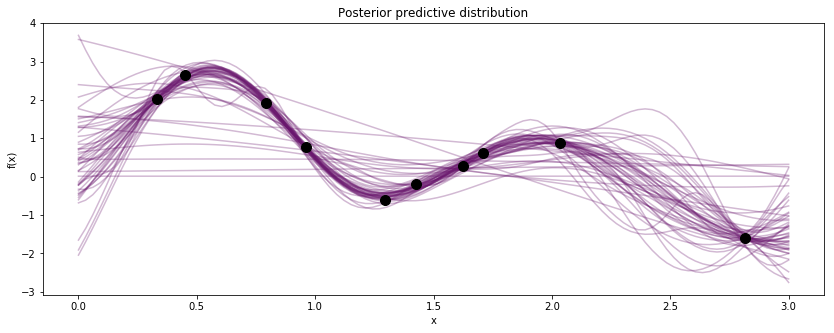

In [10]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");
